# Plot region with IFS grid points and same points averaged over 1 degree

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
cat.IFS

IFS:
  args:
    path: https://raw.githubusercontent.com/nextGEMS/catalog/main/IFS/main.yaml
  description: IFS model output
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://data.nextgems-h2020.eu


In [4]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'IFS_4.4-FESOM_5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) # tco2559-ng5-cycle3 will soon be removed

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [5]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load medium-resolution here, monthly means

In [6]:
model_lon = ds.lon.values
model_lat = ds.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

In [77]:
left, right, bottom, top = 1, 9, 53, 56, 
vmin=-3
vmax=15
cmap = cm.RdBu_r
units = '2m temperature'
figsize = (20, 8)

Test if we get the region right

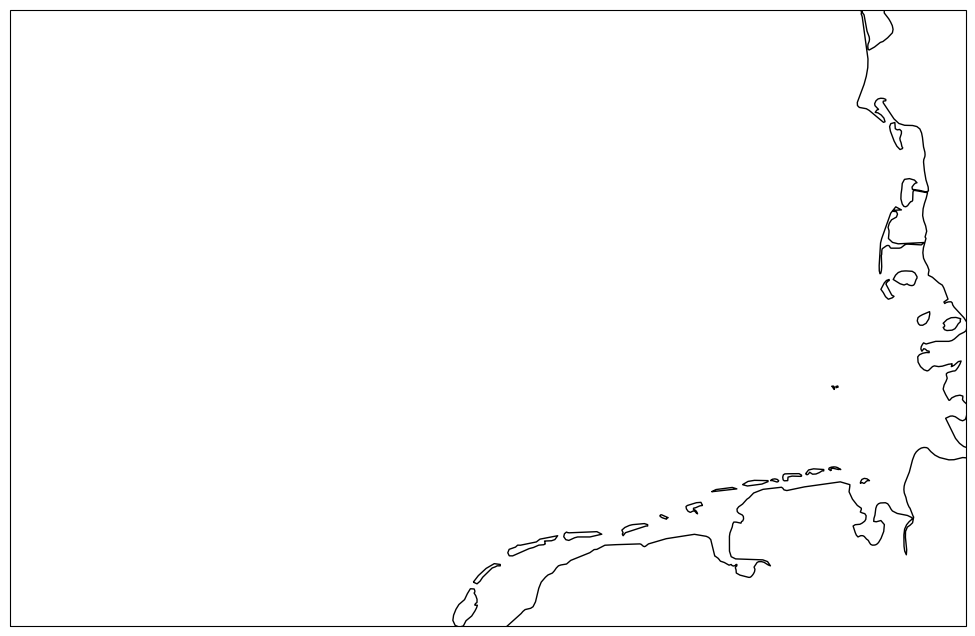

In [78]:
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((left, right, bottom, top), crs=ccrs.PlateCarree())
ax.coastlines(lw=1, resolution="10m")

In [57]:
mask = np.where((model_lon > left)&(model_lon < right)&(model_lat>bottom)&(model_lat<top))

## Testing if the region is fine

Test data

In [58]:
#if we need wind
# gridbox_x=ds['100u'].sel(time="2020-02-12 03:00:00")[mask[0]]
# gridbox_y=ds['100v'].sel(time="2020-02-12 03:00:00")[mask[0]]

In [59]:
gridbox_temp=ds['2t'].sel(time="2020-02-12 03:00:00")[mask[0]]

In [60]:
# gridbox_values = np.hypot(gridbox_x, gridbox_y).values # for wind speed
gridbox_values = gridbox_temp.values - 273.15

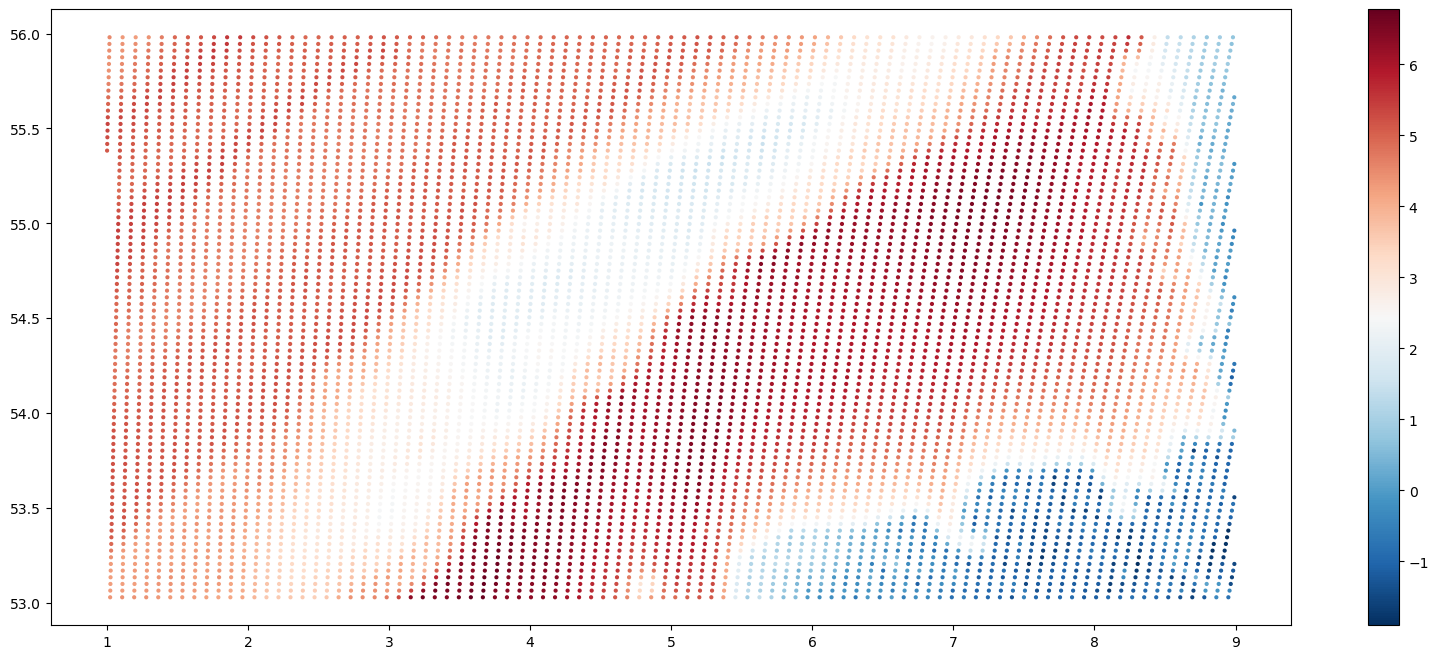

In [79]:
plt.figure(figsize=figsize)
plt.scatter(ds.lon[mask[0]], ds.lat[mask[0]],c= gridbox_values,s=4, cmap=cmap)
plt.colorbar()

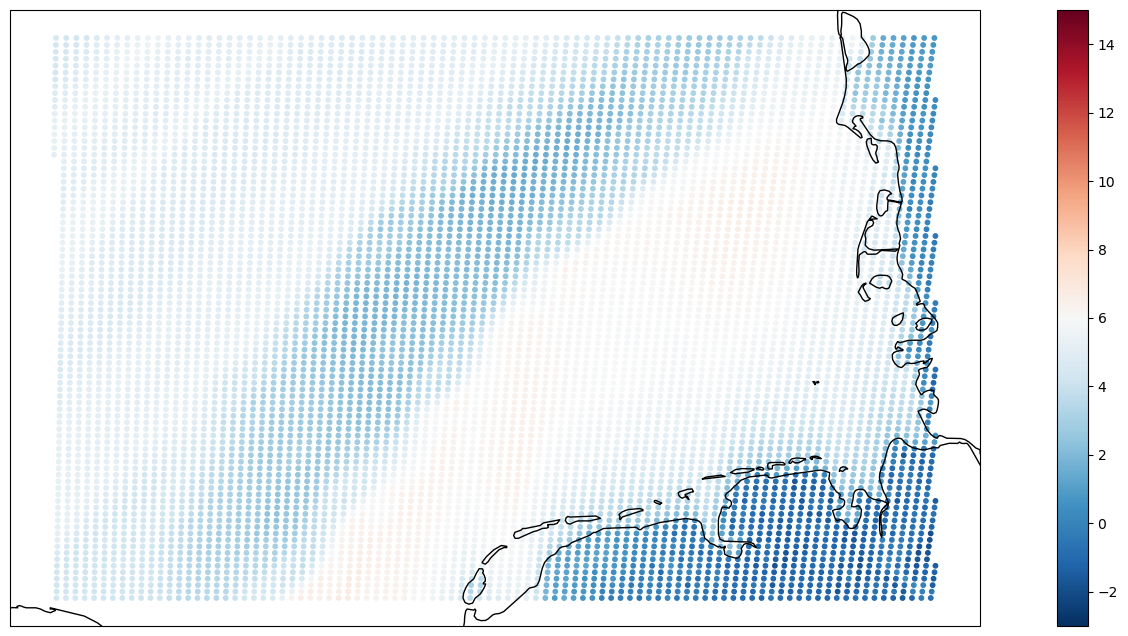

In [80]:
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Mercator())
im = ax.scatter(ds.lon[mask[0]], ds.lat[mask[0]], 
                c=gridbox_values, 
                s=10, 
                transform=ccrs.PlateCarree(),
                vmin=vmin, vmax=vmax, cmap=cmap
               )
ax.coastlines(lw=1, resolution="10m")
plt.colorbar(im)

In [81]:
lon_degree = np.append(np.arange(left, right, 1),right)
lat_degree = np.append(np.arange(bottom, top, 1), top)

In [65]:
masks = []
for lon_i in range(len(lon_degree)-1):
        for lat_i in range(len(lat_degree)-1):
            mm = np.where((ds.lat[mask[0]]>lat_degree[lat_i])&
                      (ds.lat[mask[0]]<lat_degree[lat_i+1])&
                      (ds.lon[mask[0]]>lon_degree[lon_i])&
                      (ds.lon[mask[0]]<lon_degree[lon_i+1]))
            masks.append(mm)
xxx, yyy = np.meshgrid(lon_degree, lat_degree)

In [82]:
gridbox_values_lowres = gridbox_values.copy()
point_lowres = []
indm = 0
for lon_i in range(len(lon_degree)-1):
    for lat_i in range(len(lat_degree)-1):
        gridbox_values_lowres[masks[indm]] = gridbox_values_lowres[masks[indm]].mean()
        point_lowres.append(gridbox_values_lowres[masks[indm]].mean())
        indm+=1

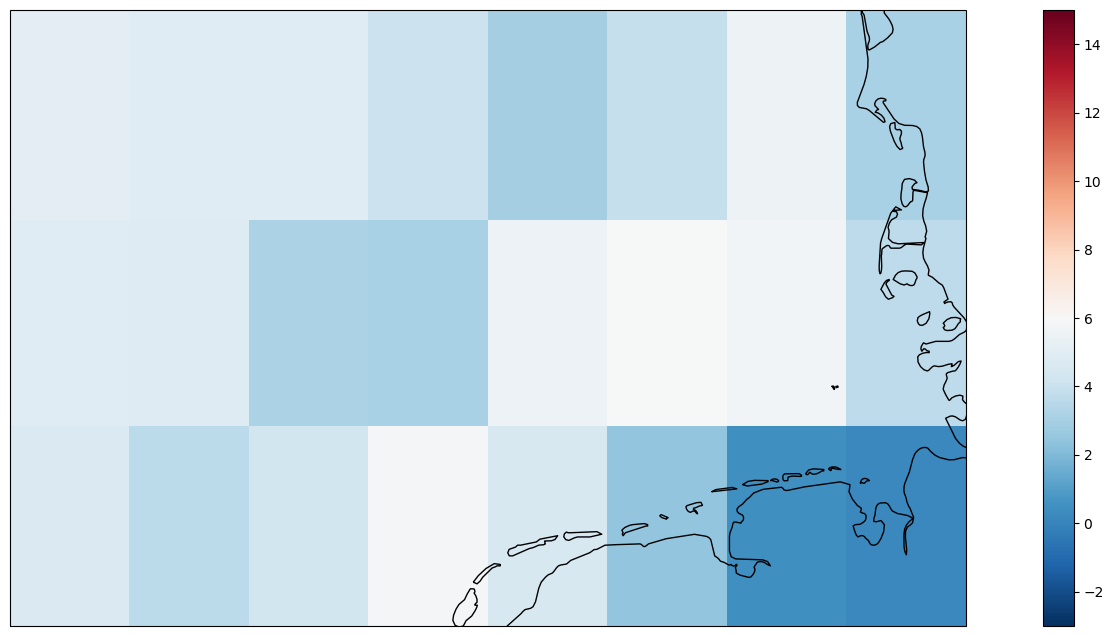

In [84]:
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Mercator())
im2 = ax.pcolormesh(xxx,
                    yyy,
                    np.array(point_lowres).reshape(xxx.shape[1]-1,xxx.shape[0]-1).T,
                    transform=ccrs.PlateCarree(),
                    vmin=vmin,
                    vmax=vmax,
                    cmap=cm.RdBu_r)
ax.coastlines(lw=1, resolution="10m")
plt.colorbar(im2)

In [85]:
for i in range(600, 601):
    # gridbox_x=ds['100u'][i,:][mask[0]]
    # gridbox_y=ds['100v'][i,:][mask[0]]
    # gridbox_values = np.hypot(gridbox_x, gridbox_y).values
    gridbox_temp = ds['2t'][i,:][mask[0]]
    gridbox_values = gridbox_temp.values - 273.15
    
    fig, axs = plt.subplots(1, 2, figsize=figsize, 
                            subplot_kw={'projection': ccrs.Mercator()},
                           constrained_layout=True)
    # First subplot
    im1 = axs[0].scatter(ds.lon[mask[0]], ds.lat[mask[0]], 
                         c=gridbox_values, s=20, 
                         transform=ccrs.PlateCarree(),
                         vmin=vmin, 
                         vmax=vmax, 
                        cmap=cmap)
    axs[0].coastlines(lw=1, resolution="10m")
    axs[0].set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())


    gridbox_values_lowres = gridbox_values.copy()
    point_lowres = []
    indm = 0
    for lon_i in range(len(lon_degree)-1):
        for lat_i in range(len(lat_degree)-1):
            gridbox_values_lowres[masks[indm]] = gridbox_values_lowres[masks[indm]].mean()
            point_lowres.append(gridbox_values_lowres[masks[indm]].mean())
            indm+=1
    im2 = axs[1].pcolormesh(xxx,
                         yyy,
                         np.array(point_lowres).reshape(xxx.shape[1]-1,xxx.shape[0]-1).T,
                         transform=ccrs.PlateCarree(),
                         vmin=vmin,
                         vmax=vmax,
                         cmap=cmap)
    # axs[1].scatter(model_lon[index[0]], model_lat[index[0]], facecolors='none', edgecolors='r', s=700, transform=ccrs.PlateCarree())
    axs[1].coastlines(lw=1, resolution="10m")
    axs[1].set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())

    # Adding shared colorbar
    fig.subplots_adjust(right=0.8)
    cb = fig.colorbar(
        im2, orientation="horizontal", ax=axs, pad=0.01, shrink=0.8
    )
    cb.set_label(units, size=10)
    # plt.savefig(f'/work/ab0995/a270088/DestinE/movies/User/temp_north_Germany/{str(i).zfill(7)}.png')
    plt.savefig(f'./test.png')
    print(i)
    plt.close(fig)


/tmp/ipykernel_987659/2444107578.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.8)


600


### Test if you figsize results in a nice looking figure

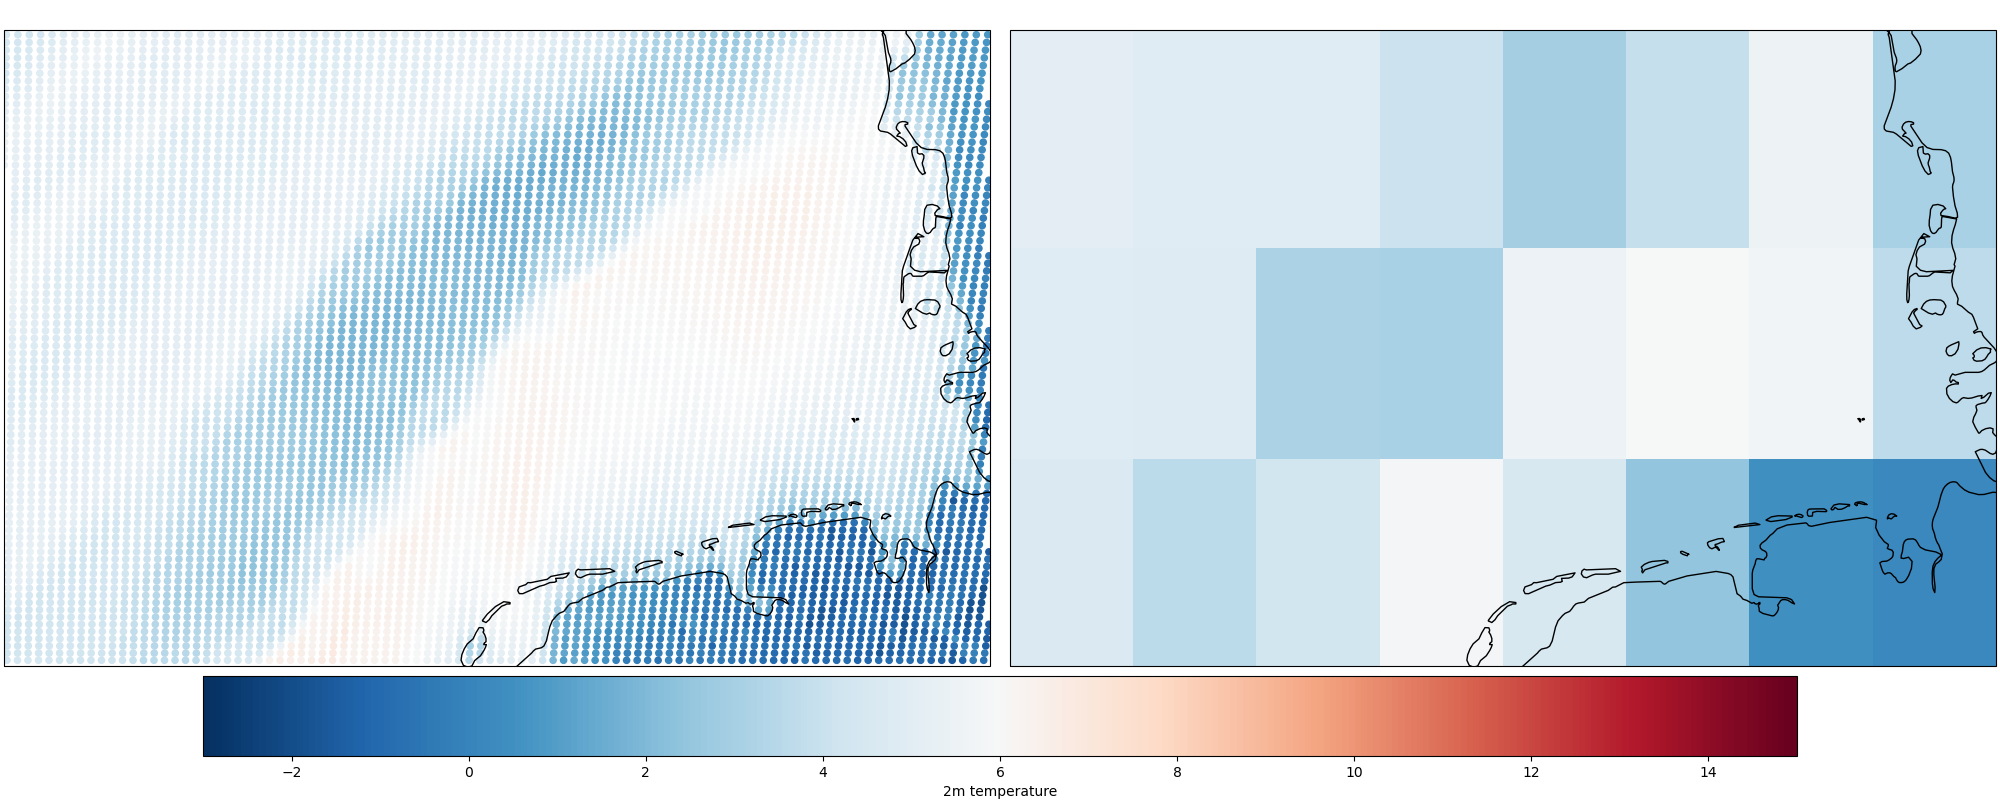

In [86]:
from PIL import Image
from IPython.display import display

image = Image.open('./test.png')
display(image)